# Import Packages

In [6]:
import pandas as pd
import os
import glob
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Import miscellaneous files and define functions

In [319]:
# Function for calculating angle between three points
def angle3pt(ax, ay, bx, by, cx, cy):
    ang = math.degrees(
        math.atan2(cy - by, cx - bx) - math.atan2(ay - by, ax - bx))
    return ang + 360 if ang < 0 else ang

# Function for calculating euclidean distance
def EuclideanDistCald(bp1xVals, bp1yVals, bp2xVals, bp2yVals, currPixPerMM):
        series = (np.sqrt((bp1xVals - bp2xVals) ** 2 + (bp1yVals - bp2yVals) ** 2)) / currPixPerMM
        return series

# Import video info file containing pixels/mm for each video
video_info = pd.read_csv('video_info.csv')

# Import feat_dict file containing dictionary with general categories for large feature dataset
with open('feat_dict.json') as json_file:
    data = json.load(json_file)
data

{'adult_body_points': ['nose_x',
  'nose_y',
  'head_center_x',
  'head_center_y',
  'ear_left_x',
  'ear_left_y',
  'ear_right_x',
  'ear_right_y',
  'neck_x',
  'neck_y',
  'side_left_x',
  'side_left_y',
  'side_right_x',
  'side_right_y',
  'body_center_x',
  'body_center_y',
  'hip_left_x',
  'hip_left_y',
  'hip_right_x',
  'hip_right_y',
  'tailbase_x',
  'tailbase_y',
  'tail_tip_x',
  'tail_tip_y',
  'tail_center_x',
  'tail_center_y',
  'tail_upper_x',
  'tail_upper_y',
  'tail_lower_x',
  'tail_lower_y'],
 'adult_body_prob': ['nose_p',
  'head_center_p',
  'ear_left_p',
  'ear_right_p',
  'neck_p',
  'side_left_p',
  'side_right_p',
  'body_center_p',
  'hip_left_p',
  'hip_right_p',
  'tailbase_p',
  'tail_tip_p',
  'tail_center_p',
  'tail_upper_p',
  'tail_lower_p'],
 'infant_and_nest_points': ['Infant1_head_x',
  'Infant1_head_y',
  'Infant1_middle_head_x',
  'Infant1_middle_head_y',
  'Infant1_middle_tail_x',
  'Infant1_middle_tail_y',
  'Infant1_tail_x',
  'Infant1_tai

# Import feature dataframes

In [5]:
%%time
# Define feature directory
features_directory = 'targets_inserted'
file_location = os.path.join(features_directory, '*.csv')

# create list of filenames for every video to be processed
# this list is the input for the video processing function
filenames = glob.glob(file_location)
videoname = []
for f in filenames:
    # establish name for output file from the input filename
    x = os.path.split(f)
    x = f
    videoname.append(x)
videoname

targets_inserted\*.csv
Wall time: 1.13 ms


['targets_inserted\\Ucn3_54_father_retreive_trial_1.csv']

In [321]:
%%time
# Read in the csv file for each feature dataframe
dfs = []
for x in videoname:
    filepath = x
    features = pd.read_csv(filepath)
    features['videoname'] = pd.Series([x] * (len(features)))
    dfs.append(features)
    print(len(dfs))

1
2
3
4
5
6
Wall time: 39.7 s


# Pull out start and end of approach annotations

In [322]:
approach_starts = {}
approach_ends = {}
for i in range(len(dfs)):
    approach_start = []
    approach_end = []
    df = dfs[i]
    # Find the frame numbers in which annotation of approach begins and the frame numbers in whic the
    # annotation of approach ends
    for j in range(len(df)):
        if j == 0:
            if df['pup_approach'][j] == 1:
                approach_start.append(j)
            else:
                continue
        elif j == len(df) - 1:
            if df['pup_approach'][j] == 1:
                approach_end.append(j)
            else:
                continue
        else:
            if df['pup_approach'][j] == 1 and df['pup_approach'][j - 1] == 0:
                approach_start.append(j)
            if df['pup_approach'][j] == 1 and df['pup_approach'][j + 1] == 0:
                approach_end.append(j)
    approach_starts[videoname[i]] = approach_start
    approach_ends[videoname[i]] = approach_end

# Adult specific features

In [323]:
# Make empty dictionaries that feature info will be added to for each video
video_areas = {}
video_circularities = {}
video_adult_nest = {}
#adult_nest_dist = {}
adult_infant = {}
adult_inf_rates = {}
ppm = video_info['pixels/mm'][0]
for i in range(len(dfs)):
    
    # Make empty lists for feature calculations in each frame to be added to
    areas = []
    circularities = []
    center_xs = []
    center_ys = []
    df = dfs[i][data['adult_body_points']]
    nest_info = dfs[i][data['infant_and_nest_points']]
    
    # Make adult hull and calculate the area and circularity of the hull in each frame
    for j in range(len(df)):
        
        p1 = Point(df['head_center_x'][j], df['head_center_y'][j])
        p2 = Point(df['ear_right_x'][j], df['ear_right_y'][j])
        p3 = Point(df['side_right_x'][j], df['side_right_y'][j])
        p4 = Point(df['hip_right_x'][j], df['hip_right_y'][j])
        p5 = Point(df['hip_left_x'][j], df['hip_left_y'][j])
        p6 = Point(df['side_left_x'][j], df['side_left_y'][j])
        p7 = Point(df['ear_left_x'][j], df['ear_left_y'][j])
        
        polygon = Polygon([p1, p2, p3, p4, p5, p6, p7])
        
        area = polygon.area
        areas.append(area)
        
        circularity = (4 * np.pi) * area / (polygon.length) ** 2
        circularities.append(circularity)
        
        center_x = polygon.centroid.x
        center_xs.append(center_x)
        center_y = polygon.centroid.y
        center_ys.append(center_y)
    
    
    video_areas[videoname[i]] = pd.Series(areas / (ppm ** 2))
    video_circularities[videoname[i]] = pd.Series(circularities)
    
    center_xs = np.array(center_xs)
    center_ys = np.array(center_ys)
    nest_xs = nest_info['nest_centroid_home_x'].values
    nest_ys = nest_info['nest_centroid_home_y'].values
    
    
    # Code for adult nest distance calculation by itself (it is added to code for adult infant distance below)
    #adult_nest_dist = EuclideanDistCald(center_xs, center_ys, nest_xs, nest_ys, ppm)
    #adult_nest_dist = pd.Series(adult_nest_dist)
    #adult_nest_shifted = adult_nest_dist.shift(periods=1)
    #adult_nest_shifted = adult_nest_shifted.fillna(0)
    #adult_nest_rate = pd.Series(adult_nest_dist.values - adult_nest_shifted.values)
    #adult_nest_rate_summed = pd.Series(adult_nest_rate.rolling(90, min_periods=1, center=True).sum())
    #adult_nest_dist_summed = pd.Series(adult_nest_dist.rolling(90, min_periods=1, center=True).sum())
    #video_adult_nest[videoname[i]] = adult_nest_rate_summed
    #adult_nest_dist[videoname[i]] = adult_nest_dist_summed
    
    # Make a dataframe of in nest for each infant point and find the average of in nest for all points for each infant
    columns = ['In_Nest_Infant1_head', 'In_Nest_Infant1_middle_head', 'In_Nest_Infant1_middle_tail',
               'In_Nest_Infant1_tail', 'In_Nest_Infant2_head', 'In_Nest_Infant2_middle_head',
               'In_Nest_Infant2_middle_tail', 'In_Nest_Infant2_tail']
    infants_in_nest = dfs[i][columns]
    
    infant1_in_nest_avg = (infants_in_nest['In_Nest_Infant1_head'] + infants_in_nest['In_Nest_Infant1_middle_head'] +
                           infants_in_nest['In_Nest_Infant1_middle_tail'] + infants_in_nest['In_Nest_Infant1_tail']) / 4
    infant2_in_nest_avg = (infants_in_nest['In_Nest_Infant2_head'] + infants_in_nest['In_Nest_Infant2_middle_head'] +
                           infants_in_nest['In_Nest_Infant2_middle_tail'] + infants_in_nest['In_Nest_Infant2_tail']) / 4
    
    infant1_center_xs = dfs[i]['Inf1_points_avg_x']
    infant1_center_ys = dfs[i]['Inf1_points_avg_y']
    infant2_center_xs = dfs[i]['Inf2_points_avg_x']
    infant2_center_ys = dfs[i]['Inf2_points_avg_y']
    
    # Calculate the distance between the adult and the infant depending on which infant is in the nest, along with
    # the distance between the adult and the nest
    adult_infants_dist = []
    adult_nest_dist = []
    for j in range(len(df)):
        
        if infant1_in_nest_avg[j] > 0 and infant2_in_nest_avg[j] == 0:
            adult_infant = EuclideanDistCald(center_xs[j], center_ys[j], infant2_center_xs[j], 
                                                  infant2_center_ys[j], ppm)
            adult_infants_dist.append(adult_infant)
            
            adult_nest = EuclideanDistCald(center_xs[j], center_ys[j], nest_xs[j], nest_ys[j], ppm)
            adult_nest_dist.append(adult_nest)
        elif infant1_in_nest_avg[j] == 0 and infant2_in_nest_avg[j] > 0:
            adult_infant = EuclideanDistCald(center_xs[j], center_ys[j], infant1_center_xs[j], 
                                                  infant1_center_ys[j], ppm)
            adult_infants_dist.append(adult_infant)
            
            adult_nest = EuclideanDistCald(center_xs[j], center_ys[j], nest_xs[j], nest_ys[j], ppm)
            adult_nest_dist.append(adult_nest)
        elif infant1_in_nest_avg[j] == 0 and infant2_in_nest_avg[j] == 0:
            adult_infant1 = EuclideanDistCald(center_xs[j], center_ys[j], infant1_center_xs[j], 
                                                  infant1_center_ys[j], ppm)
            adult_infant2 = EuclideanDistCald(center_xs[j], center_ys[j], infant2_center_xs[j], 
                                                  infant2_center_ys[j], ppm)
            
            adult_infants_dist.append(min(adult_infant1, adult_infant2))
            
            adult_nest = EuclideanDistCald(center_xs[j], center_ys[j], nest_xs[j], nest_ys[j], ppm)
            adult_nest_dist.append(adult_nest)
        else:
            adult_infants_dist.append(20)
            adult_nest_dist.append(0)
    # Sum the adult infant distances and the adult nest distances over 90 frames, with the present frame in the 
    # middle of the 90 frame window
    adult_infants_dist = pd.Series(adult_infants_dist)
    adult_inf_dist_shifted = adult_infants_dist.shift(periods=1)
    adult_inf_dist_shifted = adult_inf_dist_shifted.fillna(0)
    adult_inf_rate = pd.Series(adult_infants_dist.values - adult_inf_dist_shifted.values)
    adult_infants_dist = adult_infants_dist.rolling(90, min_periods=1, center=True).sum()
    adult_inf_rate = adult_inf_rate.rolling(90, min_periods=1, center=True).sum()
    adult_inf_rates[videoname[i]] = adult_inf_rate
    
    adult_nest_dist = pd.Series(adult_nest_dist)
    adult_nest_shifted = adult_nest_dist.shift(periods=1)
    adult_nest_shifted = adult_nest_shifted.fillna(0)
    adult_nest_rate = pd.Series(adult_nest_dist.values - adult_nest_shifted.values)
    adult_nest_rate_summed = pd.Series(adult_nest_rate.rolling(90, min_periods=1, center=True).sum())
    adult_nest_dist_summed = pd.Series(adult_nest_dist.rolling(90, min_periods=1, center=True).sum())
    video_adult_nest[videoname[i]] = adult_nest_rate_summed

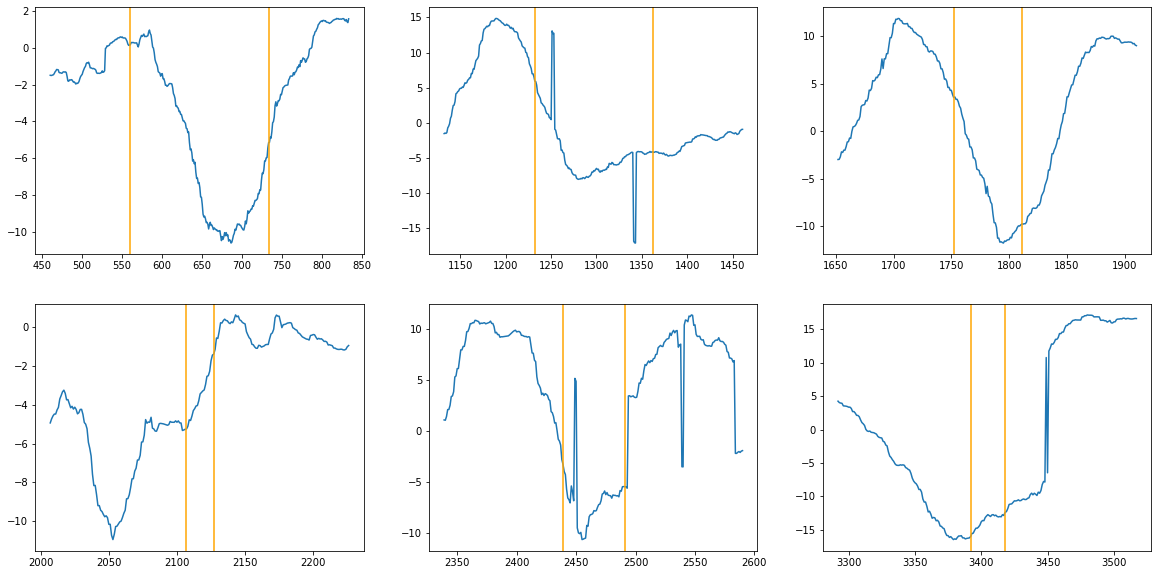

In [22]:
# Plot the curve of either the adult nest or adult infant distances against the labeled starts and end of the approach
# behavior
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(approach_starts[videoname[0]])):
    ad_nest = adult_inf_rates[videoname[0]]
    starts = approach_starts[videoname[0]]
    ends = approach_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 100, ends[i] + 100)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, ad_nest[starts[i] - 100:ends[i] + 100])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

In [326]:
# adult body angle
adult_angles = {}
adult_angles_rate = {}
for i in range(len(dfs)):
    
    # Use the angle function above and the head_center, neck and body_center points to calculate the angle made by
    # these body parts
    adult_angle = dfs[i].apply(
                lambda x: angle3pt(x['head_center_x'], x['head_center_y'], x['neck_x'], x['neck_y'], 
                                   x['body_center_x'], x['body_center_y']), axis=1)
    adult_angle = adult_angle.rolling(90, min_periods=1, center=True).mean()   
    adult_angle_shifted = adult_angle.shift(periods=1)
    adult_angle_shifted = adult_angle_shifted.fillna(0)
    adult_angle_rate = pd.Series(adult_angle.values - adult_angle_shifted)
    adult_angle_rate = adult_angle_rate.rolling(90, min_periods=1, center=True).mean()  
    adult_angles_rate[videoname[i]] = adult_angle_rate
    adult_angles[videoname[i]] = adult_angle

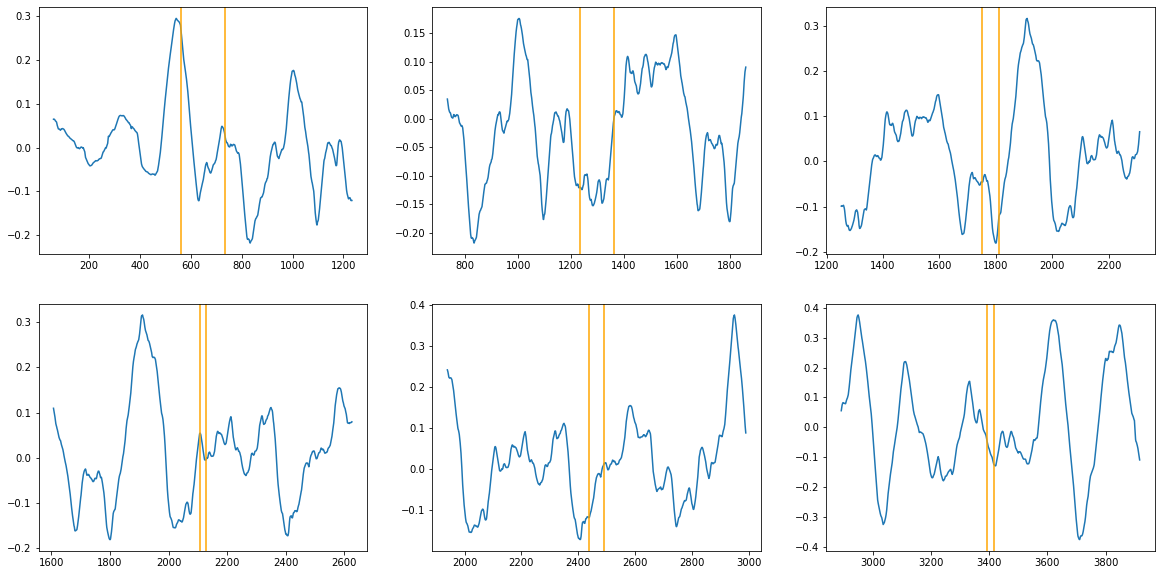

In [26]:
# Plot the curve of the calculated adult body angle against the labeled approach behaviors
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(approach_starts[videoname[0]])):
    angles = adult_angles_rate[videoname[0]]
    starts = approach_starts[videoname[0]]
    ends = approach_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 500, ends[i] + 500)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, angles[starts[i] - 500:ends[i] + 500])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')
    
    

In [327]:
# Find the movement of the adult by adding all the adult movement columns (except for any column involving the
# nose or tail), summed over 90 frames, with the present frame in the middle of the 90 frame window
video_adult_movement = {}
for i in range(len(dfs)):
    adult_movement = dfs[i][data['movement_adult']]
    adult_movement_summed = pd.Series(np.zeros(len(adult_movement)))
    for column in adult_movement.columns:
        if 'nose' in column or 'tail' in column or 'all' in column:
            continue
        adult_movement_summed = adult_movement_summed + adult_movement[column]
    adult_movement_summed = pd.Series(adult_movement_summed.rolling(90, min_periods=1, center=True).mean())
    video_adult_movement[videoname[i]] = adult_movement_summed

In [329]:
# Get in nest for the adult body, and find the minimum in a 120 frame window (with the present frame in the middle
# of that window)
leave_nest_sums = {}
for i in range(len(dfs)):
    leave_nest_summed = pd.Series(dfs[i]['In_Nest_Adult_body'].diff().rolling(120, min_periods=1, center=True).min())
    
    # Get the in nest columns for both infant and calculate the in nest averages for both infants by averaging
    # the in nest value for all the points in each infant
    columns = ['In_Nest_Infant1_head', 'In_Nest_Infant1_middle_head', 'In_Nest_Infant1_middle_tail',
               'In_Nest_Infant1_tail', 'In_Nest_Infant2_head', 'In_Nest_Infant2_middle_head',
               'In_Nest_Infant2_middle_tail', 'In_Nest_Infant2_tail']
    infants_in_nest = dfs[i][columns]
    
    infant1_in_nest_avg = (infants_in_nest['In_Nest_Infant1_head'] + infants_in_nest['In_Nest_Infant1_middle_head'] +
                           infants_in_nest['In_Nest_Infant1_middle_tail'] + infants_in_nest['In_Nest_Infant1_tail']) / 4
    infant2_in_nest_avg = (infants_in_nest['In_Nest_Infant2_head'] + infants_in_nest['In_Nest_Infant2_middle_head'] +
                           infants_in_nest['In_Nest_Infant2_middle_tail'] + infants_in_nest['In_Nest_Infant2_tail']) / 4
    
    # If both infants are in the nest, change every leave nest summed value to 0
    for j in range(len(leave_nest_summed)):
        if infant1_in_nest_avg[j] == 1 and infant2_in_nest_avg[j] == 1:
            leave_nest_summed.iat[j] = 0
    leave_nest_sums[videoname[i]] = leave_nest_summed

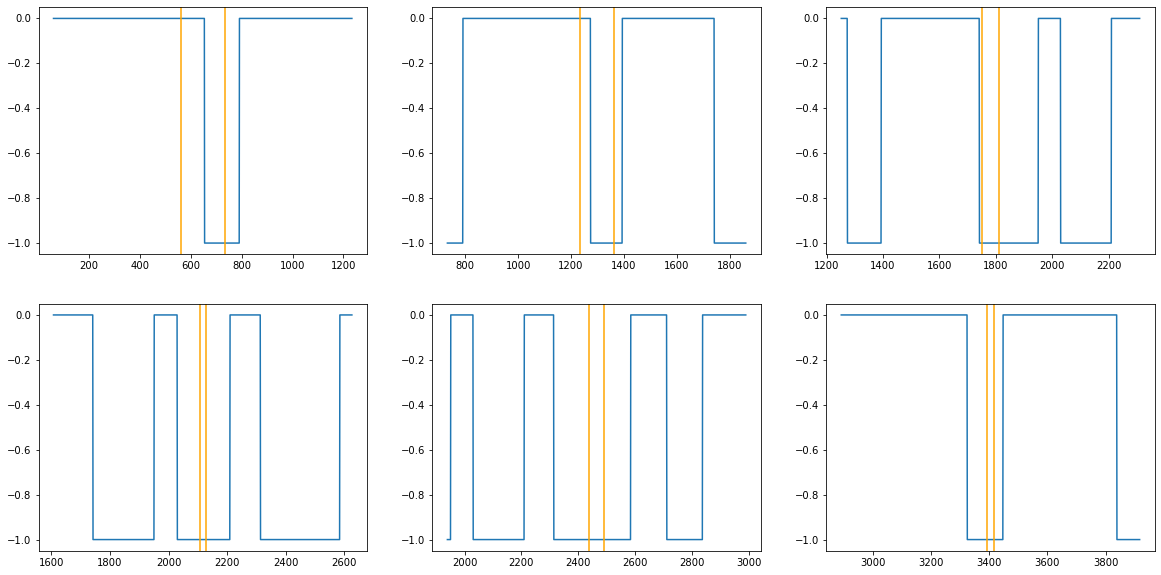

In [170]:
# Plot the curve for adult leave nest against the labeled starts and ends of the approach behavior
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(approach_starts[videoname[0]])):
    angles = pd.Series(dfs[0]['In_Nest_Adult_body'].diff().rolling(120, min_periods=1, center=True).min())
    starts = approach_starts[videoname[0]]
    ends = approach_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 500, ends[i] + 500)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, angles[starts[i] - 500:ends[i] + 500])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

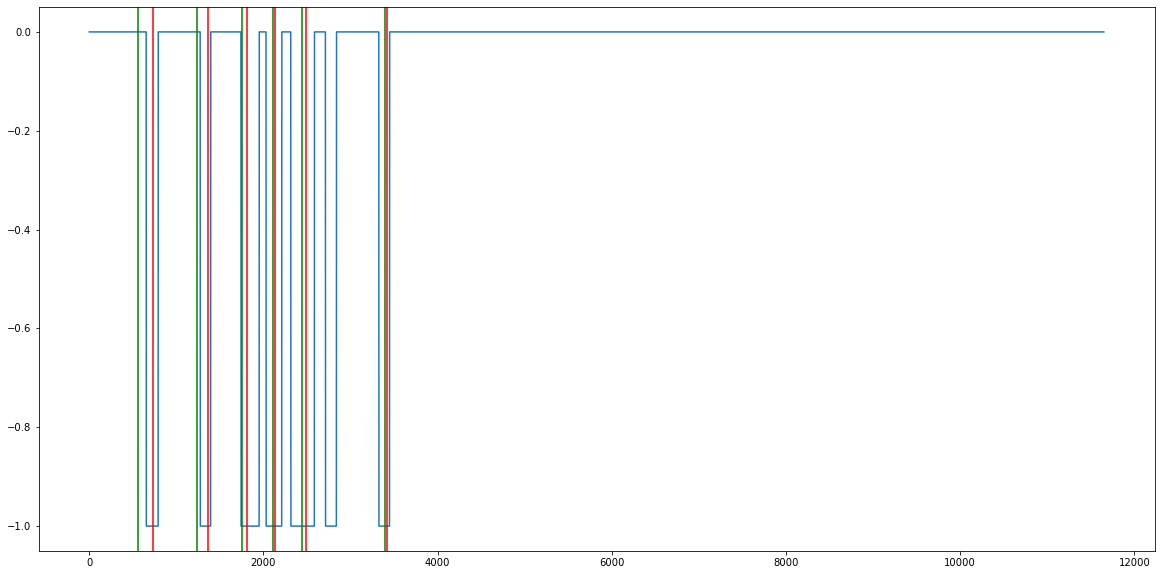

In [175]:
# Plot the curve of adult leave nest over the entire video, with the green lines representing the starts of approach
# and red lines representing the ends of approach
plt.figure(figsize=(20, 10))
ad_mov = leave_nest_summed
plt.plot(ad_mov.index, ad_mov)
for i in range(len(approach_starts[videoname[0]])):
    starts = approach_starts[videoname[0]]
    ends = approach_ends[videoname[0]]
    plt.axvline(starts[i], color='green')
    plt.axvline(ends[i], color='red')

# Infant specific features

In [324]:
# Get the total movement of all infant points and sum over 150 frames, with the present frame in the middle of the 
# 150 frames
infants_mov = {}
for i in range(len(dfs)):
    inf_mov = dfs[i]['Total_movement_infants']
    inf_mov = pd.Series(inf_mov)
    inf_mov = pd.Series(inf_mov.rolling(150, min_periods=1, center=True).mean())
    infants_mov[videoname[i]] = inf_mov

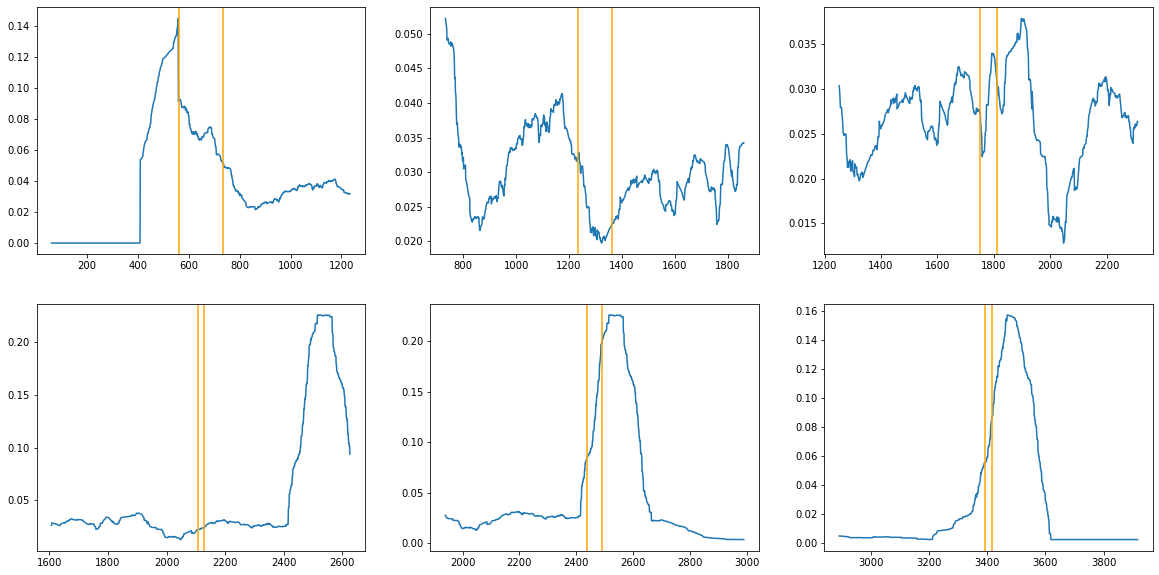

In [23]:
# Plot the curve of the infant movement against the labeled starts and ends of the approach behavior
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(approach_starts[videoname[0]])):
    inf_mov = infants_mov[videoname[0]]
    starts = approach_starts[videoname[0]]
    ends = approach_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 500, ends[i] + 500)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, inf_mov[starts[i] - 500:ends[i] + 500])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')

In [325]:
# Calculate the infant-nest distances, averaged over both infants and summed over 90 frames, with the present frame
# in the middle of the 90 frame window
infs_nest_rates = {}
for i in range(len(dfs)):

    feats_cat = dfs[i]
    inf1_nest = feats_cat['Inf1_points_avg_to_nest_centroid_home']
    inf2_nest = feats_cat['Inf2_points_avg_to_nest_centroid_home']

    inf1_nest_shifted = inf1_nest.shift(periods=1)
    inf1_nest_shifted = inf1_nest_shifted.fillna(0)
    inf2_nest_shifted = inf2_nest.shift(periods=1)
    inf2_nest_shifted = inf2_nest_shifted.fillna(0)

    inf1_nest_rate = pd.Series(inf1_nest.values - inf1_nest_shifted.values)
    inf1_nest_rate_summed = pd.Series(inf1_nest_rate.rolling(90, min_periods=1, center=True).sum())
    inf2_nest_rate = pd.Series(inf2_nest.values - inf2_nest_shifted.values)
    inf2_nest_rate_summed = pd.Series(inf2_nest_rate.rolling(90, min_periods=1, center=True).sum())

    infs_nest_rate_summed = (inf1_nest_rate_summed + inf2_nest_rate_summed) / 2
    infs_nest_rates[videoname[i]] = abs(infs_nest_rate_summed)

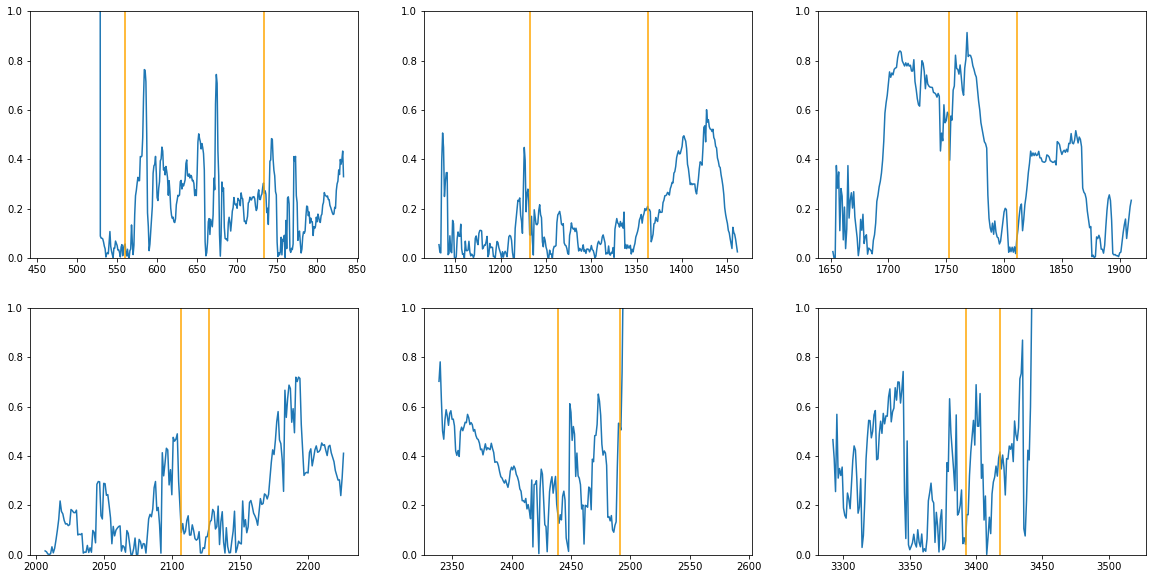

In [122]:
# Plot the infant nest distances against the labeled starts and ends of the approach behavior
plt.subplots(2, 3, sharey=True, figsize=(20, 10))
count = 1
for i in range(len(approach_starts[videoname[0]])):
    inf_nest = infs_nest_rates[videoname[0]]
    starts = approach_starts[videoname[0]]
    ends = approach_ends[videoname[0]]
    fig = plt.subplot(2, 3, count)
    x_range = range(starts[i] - 100, ends[i] + 100)
    x_list = list(x_range)
    count += 1
    plt.plot(x_range, inf_nest[starts[i] - 100:ends[i] + 100])
    plt.axvline(starts[i], color='orange')
    plt.axvline(ends[i], color='orange')
    plt.ylim([0, 1])

#  Euclidean distance PCA

In [328]:
for i in range(len(dfs)):
    # Get the point-to-point euclidean distances within the adult body for all the videos
    videoname_column = dfs[i]['videoname']
    euclid_dist = dfs[i][data['adult_distances']]
    if i == 0:
        euclid_dist_concat = euclid_dist
        videonames = videoname_column
    else:
        euclid_dist_concat = pd.concat([euclid_dist_concat, euclid_dist], ignore_index=True)
        videonames = pd.concat([videonames, videoname_column], ignore_index=True)

# Don't include any euclidean distances involving nose or tail points
for column in euclid_dist_concat.columns:
    if 'nose' in column or 'tail' in column:
        euclid_dist_concat = euclid_dist_concat.drop([column], axis=1)

# Calculate the PC's explaining 70% of the variance in adult euclidean distance data
scaler = StandardScaler()
scaled_euclid = scaler.fit_transform(euclid_dist_concat)
    
pca = PCA(0.7)
pca_euclid = pca.fit_transform(scaled_euclid)
euclid_dist_pca = pd.DataFrame(pca_euclid)

euclid_dist_pcas = []
euclid_dist_pca = pd.concat([euclid_dist_pca, videonames], axis=1)
for i in range(len(videoname)):
    video_pcas = euclid_dist_pca[euclid_dist_pca['videoname'] == videoname[i]]
    video_pcas = video_pcas.reset_index()
    video_pcas = video_pcas.drop(['videoname', 'index'], axis=1)
    euclid_dist_pcas.append(video_pcas)
euclid_dist_pcas

[              0         1         2
 0      1.332688  1.510831  0.708829
 1      1.442876  1.529738  0.747270
 2      1.429026  1.538807  0.742850
 3      1.447084  1.509433  0.703759
 4      1.459611  1.506360  0.721554
 ...         ...       ...       ...
 11646  0.544088  0.769047 -0.621838
 11647  0.544064  0.769059 -0.621977
 11648  0.591591  0.801888 -0.538592
 11649  0.611791  0.790174 -0.506073
 11650  0.654836  0.782979 -0.468704
 
 [11651 rows x 3 columns],
               0         1         2
 0     -0.739862 -0.186914  0.038375
 1     -0.728110 -0.175394  0.010829
 2     -0.919478 -0.412991 -0.034837
 3     -0.899492 -0.404629 -0.016095
 4     -0.961321 -0.424954  0.045721
 ...         ...       ...       ...
 13951 -1.647098 -0.836800  0.789230
 13952 -1.646561 -0.836258  0.790287
 13953 -1.646561 -0.836258  0.790287
 13954 -1.649383 -0.831678  0.786174
 13955 -1.649456 -0.842035  0.782933
 
 [13956 rows x 3 columns],
               0         1         2
 0     -2.253101 

# ML model for approach

In [331]:
# Make lists for train and test datasets where each extracted feature dataframe goes in either the train
# or test list below
feats_dfs_train = []
feats_dfs_test = []
for i in range(len(videoname)):
    
    # Concatenate all the feature data along with retrieval annotations into a dataframe and label columns
    features_df = pd.DataFrame()
    approach = dfs[i]['pup_approach']
    features_df = pd.concat([video_adult_nest[videoname[i]], adult_inf_rates[videoname[i]], infants_mov[videoname[i]],
                            infs_nest_rates[videoname[i]], adult_angles[videoname[i]], euclid_dist_pcas[i],
                             video_adult_movement[videoname[i]], video_areas[videoname[i]],
                             video_circularities[videoname[i]], leave_nest_sums[videoname[i]], approach], axis=1)
    
    features_df.columns = ['summed_adult_nest_rates', 'summed_adult_infant_rates', 'summed_infants_movement',
                           'summed_infant_nest_rates', 'summed_adult_angles', 'euclid_pc1', 'euclid_pc2', 'euclid_pc3',
                           'summed_adult_movement', 'area', 'circularity', 'summed_nest_exits',
                           'pup_approach']

    # Choose which videos go in the train and test set
    #if i == 0:
    feats_dfs_test.append(features_df)
    #else:
    #    feats_dfs_train.append(features_df)
features_df

,summed_adult_nest_rates,summed_adult_infant_rates,summed_infants_movement,summed_infant_nest_rates,summed_adult_angles,euclid_pc1,euclid_pc2,euclid_pc3,summed_adult_movement,area,circularity,summed_nest_exits,pup_approach
0,3.523441e+00,3.252867e+01,0.0,0.000000,171.098795,0.792429,0.159850,0.930994,6.660063,11.437301,0.844712,0.0,0.0
1,3.523441e+00,3.252867e+01,0.0,0.000000,171.060805,0.739555,0.110951,0.936114,6.515279,11.304894,0.841690,0.0,0.0
2,3.509756e+00,3.251792e+01,0.0,0.000000,171.024932,0.735977,0.076715,0.970585,6.377958,11.314237,0.843977,0.0,0.0
3,3.513795e+00,3.251678e+01,0.0,0.000000,170.990439,0.748064,0.091303,0.969662,6.245766,11.339317,0.844086,0.0,0.0
4,3.513795e+00,3.251678e+01,0.0,0.000000,170.957353,0.724469,0.074388,0.939626,6.118301,11.288982,0.843434,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12810,2.486900e-14,1.776357e-14,0.0,0.078470,200.177372,0.348812,0.396885,-0.387408,0.096730,10.512126,0.792880,0.0,0.0
12811,2.486900e-14,1.776357e-14,0.0,0.078470,200.219696,0.311950,0.428868,-0.364100,0.098704,10.467476,0.791838,0.0,0.0
12812,2.486900e-14,1.776357e-14,0.0,0.088142,200.285587,0.311958,0.428871,-0.364031,0.099856,10.467547,0.791842,0.0,0.0
12813,2.486900e-14,1.776357e-14,0.0,0.062720,200.354345,0.311215,0.428951,-0.364539,0.101672,10.467319,0.791892,0.0,0.0


In [332]:
# Concatenate the dataframes in the train and test set
#feats_df_train = (pd.concat(feats_dfs_train).reset_index()).drop(['index'], axis=1)
feats_df_test = (pd.concat(feats_dfs_test).reset_index()).drop(['index'], axis=1)

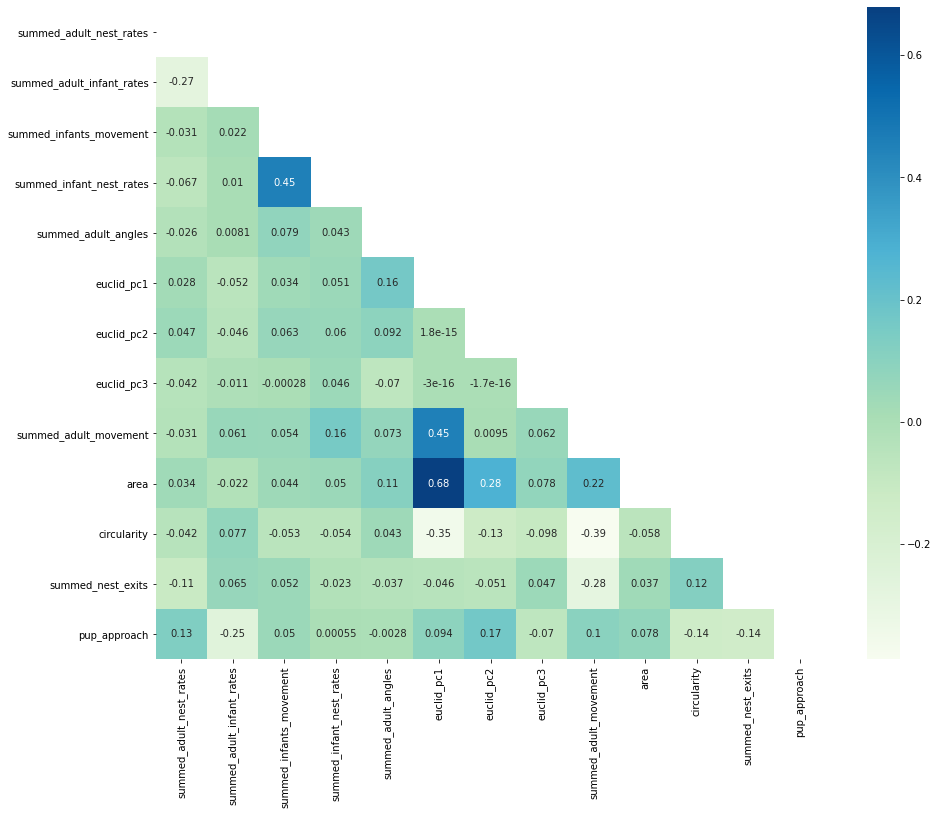

In [333]:
# Make a correlation matrix for the concatenated dataframe
plt.figure(figsize=(15,12))
correlation = feats_df_test.corr()
sns.heatmap(correlation, cmap="GnBu", 
            mask=np.triu(np.ones_like(correlation, dtype=bool)), annot=True)

In [359]:
from sklearn.model_selection import train_test_split

# Separate the concatenate train and test dataframes into data and target dataframes
target_train = feats_df_train['pup_approach']
data_train = feats_df_train.drop(['pup_approach'], axis=1)

target = feats_df_test['pup_approach']
data = feats_df_test.drop(['pup_approach'], axis=1)

# Perform a train-test split on the data and target with a test size of 20% of the dataframe
data_train, data_test, target_train, target_test = train_test_split(
     data, target, test_size=0.2, random_state=42)

In [360]:
# Make a random forest classifier
rfc = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1,
                                     criterion='entropy', min_samples_leaf=10, bootstrap=True,
                                     verbose=1)

In [361]:
# Train the rfc on the training data and target
rfc.fit(data_train, target_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=10, n_estimators=200, n_jobs=-1,
                       verbose=1)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


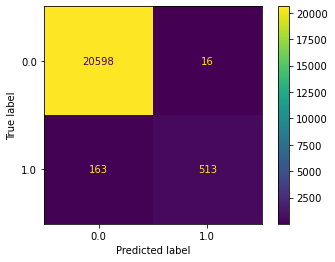

In [362]:
# Make a confusion matrix of the rfc tested on the test set
from sklearn.metrics import plot_confusion_matrix

_ = plot_confusion_matrix(rfc, data_test, target_test)

In [363]:
from sklearn.metrics import balanced_accuracy_score

# Use the rfc to make predictions on the test set and perform a balanced accuracy test of the ground truth
# annotation against the predicitons
predictions = rfc.predict(data_test)

balanced_accuracy_test = balanced_accuracy_score(target_test, predictions)
#balanced_accuracy_all = balanced_accuracy_score(target_full, full_predictions)
print(f"Balanced accuracy test: {balanced_accuracy_test:.3f}")
#print(f"Balanced accuracy full: {balanced_accuracy_all:.3f}")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Balanced accuracy test: 0.879


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


In [364]:
# Find the precision and recall of the predictions against the ground truth annotations for approach 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('precision (tp / (tp + fp)): ', precision_score(target_test, predictions) * 100, '%')
print('precision (tp / (tp + fn)): ', recall_score(target_test, predictions) * 100, '%')

precision (tp / (tp + fp)):  96.97542533081285 %
precision (tp / (tp + fn)):  75.88757396449705 %


In [311]:
# Produce a dataframe of the prediciton probability for the test set when tested on the model
probs = pd.DataFrame(rfc.predict_proba(data_test))
probs_threshold = []
for i in range(len(probs)):
    # Make a test set-length list of 1's and 0's with every frame above a certain threshold labeled as 1
    if probs[1][i] > 0.3:
        probs_threshold.append(1)
    else:
        probs_threshold.append(0)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [312]:
# Find the number of false positives and negatives after post-processing the predictions based on prediction probability
total = 0
fp = 0
fn = 0
trues = 0
for i in range(len(probs_threshold)):
    if target_test[i] == 1:
        total += 1
        if probs_threshold[i] == 0:
            fn += 1
        if probs_threshold[i] == 1:
            trues += 1
    if target_test[i] == 0 and probs_threshold[i] == 1:
        fp +=1
print(total, fn, fp, trues)

KeyError: 1

In [290]:
# Post-process the predictions again by taking the summed value of prediction values for each frame, and changing
# the prediction if it is above or below a certain threshold
summed_100_window_cutoff = 20
summed_100_window_threshold = 50
ones_to_zeros = []
pt = pd.Series(probs_threshold)
for i in range(len(pt)):
    if pt[i] == 1 and pt[i - 50: i + 50].sum() < summed_100_window_cutoff:
        pt.iat[i] = 0
        ones_to_zeros.append(i)
    if pt[0] == 0 and pt[i - 50: i + 50].sum() > summed_100_window_threshold and ones_to_zeros.count(i) == 0:
        pt.iat[i] = 1

In [291]:
# Calculate the number of false positives and negatives again after the previous step
total = 0
fp = 0
fn = 0
trues = 0
for i in range(len(pt)):
    if target_test[i] == 1:
        total += 1
        if pt[i] == 0:
            fn += 1
        if pt[i] == 1:
            trues += 1
    if target_test[i] == 0 and pt[i] == 1:
        fp +=1
print(total, fn, fp, trues)

690 439 343 251


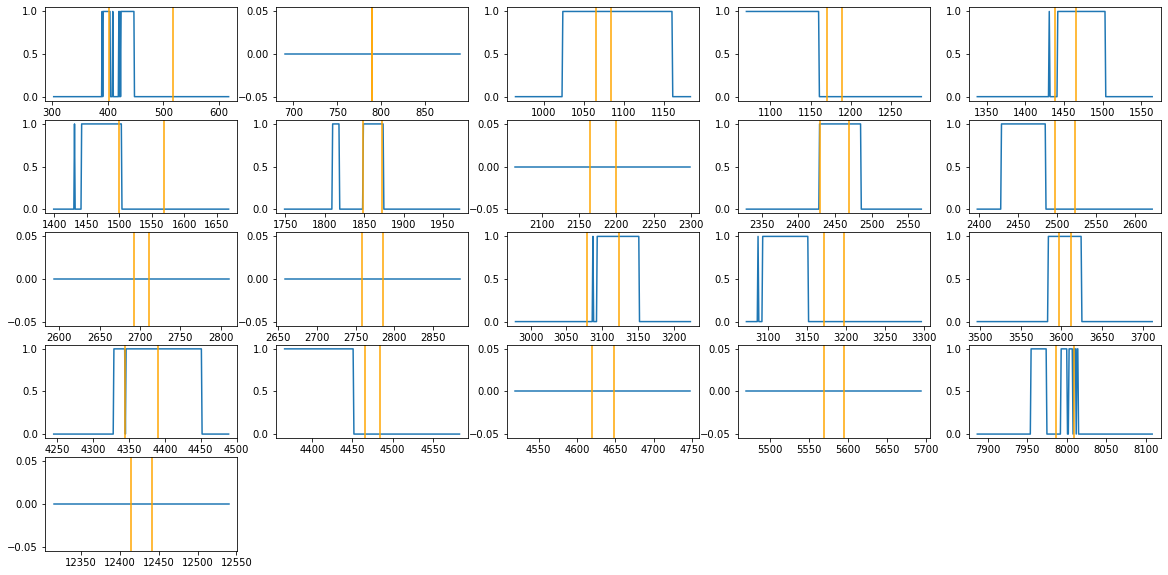

In [297]:
# Plot the predictions of the model against the actual labels of starts and ends of the approach behavior
plt.subplots(4, 5, sharey=True, figsize=(20,10))
count = 1
for i in range(len(approach_starts[videoname[3]])):
    plt.subplot(5, 5, count)
    approach_s = approach_starts[videoname[3]]
    approach_e = approach_ends[videoname[3]]
    x_range = range(approach_s[i] - 100, approach_e[i] + 100)
    x_list = list(x_range)
    approach_range = (range(approach_s[i], approach_e[i] + 1))
    approach_list = list(approach_range)
    plt.plot(x_list, pt[approach_s[i] - 100: approach_e[i] + 100])
    plt.axvline(approach_s[i], label='Start of Approach', color='orange')
    plt.axvline(approach_e[i], label='End of Approach', color='orange')
    #plt.fill_between(approach_list, predictions[approach_s[i]: approach_e[i] + 1], 1, color='red')
    count += 1

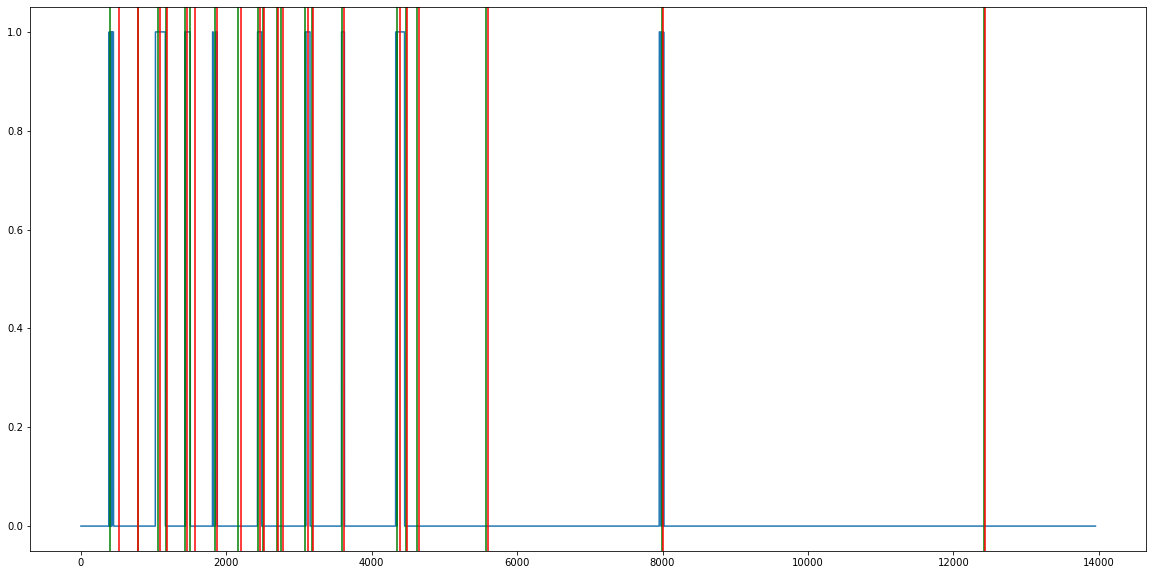

In [295]:
# Plot the curve of the ml predictions over an entire video against the labeled approaches, with the starts of
# approaches shown in red and the ends of approaches shown in green
plt.figure(figsize=(20, 10))
ad_mov = pd.Series(pt)
plt.plot(ad_mov.index, ad_mov)
for i in range(len(approach_starts[videoname[3]])):
    starts = approach_starts[videoname[3]]
    ends = approach_ends[videoname[3]]
    plt.axvline(starts[i], color='green')
    plt.axvline(ends[i], color='red')

In [270]:
# Find the balanced accuracy of the predictions against the labeled approaches
balanced_accuracy_test = balanced_accuracy_score(target_test, pt)
#balanced_accuracy_all = balanced_accuracy_score(target_full, full_predictions)
print(f"Balanced accuracy test: {balanced_accuracy_test:.3f}")
#print(f"Balanced accuracy full: {balanced_accuracy_all:.3f}")

Balanced accuracy test: 0.534
